In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.manifold import TSNE
from imblearn.over_sampling import RandomOverSampler

# A convolutional neural network

We define a neural network with :
- Two 1d convolution layers (with a maxpooling step and a relu activation function) followed by 
- Two fully connected layers (with a sigmoid activation function at the end to do a binary classification)
- We use dropout and L2 regularization techniques to improve generalization. 

We process the data with the following steps :
- Standardization : i.e. scale each data to have mean = 0 and variance = 1 
- Remove outliers with a certain threshold (like 3)
- Smoothening : Apply a (small) moving average to smooth slightly the data
- Remove high frequency : Apply a Fourier transform, set high frequency (like above 500) to 0, apply inverse Fourier transform 

In [2]:
class CNN_nn(nn.Module):
    def __init__(self,input_size, kernel_number, sequence_length, kernel_size, stride = 1, frequency_threshold = 500, outlier_threshold = 4, average_size = 1,  output_size = 1):
        super(CNN_nn, self).__init__()
        #Attributes
        self.input_size = input_size #input size
        self.output_size = output_size #output size
        self.kernel_number = kernel_number #number of kernels
        self.kernel_size = kernel_size
        self.stride = stride
        self.frequency_threshold = frequency_threshold
        self.outlier_threshold = outlier_threshold
        self.average_size = average_size
        self.sequence_length = sequence_length-self.average_size+1 #length of the 1d input sequence

        self.cnn1 = nn.Conv1d(self.input_size,2*self.kernel_number,self.kernel_size,self.stride) #Conv 1d
        self.cnn2 = nn.Conv1d(2*self.kernel_number,self.kernel_number,self.kernel_size,self.stride) #Conv 1d
        self.max_pool = nn.MaxPool1d(4) #Max pooling

        self.drop = nn.Dropout(p = 0.25)

        example = self.cnn1(torch.randn(1,self.input_size,self.sequence_length)) # one batch to get the output length dimension
        example = self.max_pool(example)
        example = self.cnn2(example)
        example = self.max_pool(example)
        self.Lout = example.size(2) #Length of the output sequence

        self.fc1 = nn.Linear(self.kernel_number*self.Lout, self.kernel_number) #fully connected linear
        self.fc2 = nn.Linear(self.kernel_number, self.output_size) #fully connected linear

        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def smoothening(self,X):
        rows = X.shape[0]
        columns = X.shape[1]
        res = np.zeros((rows,columns-self.average_size+1))
        for j in range(rows):
            for i in range(columns-self.average_size+1):
                res[j,i] = sum(X[j,i:i+self.average_size])/self.average_size
        return res

    def process_features(self, X, frequency_threshold, outlier_threshold):
        #Standardisation
        m = X.mean(axis = 1)
        v = X.var(axis = 1)
        X_torch = np.zeros(X.shape)
        for j in range(X.shape[1]):
            X_torch[:,j] = (X[:,j]-m)/np.sqrt(v)

        #Remove outliers
        X_torch = self.remove_outliers(X_torch,outlier_threshold)

        #Smoothening with moving average
        X_torch = self.smoothening(X_torch)

        #Remove remaining high frequency
        X_torch = self.remove_high_frequency(X_torch,frequency_threshold)
        
        #Reshaping
        X_torch = Variable(torch.Tensor(X_torch))
        X_torch = X_torch.reshape(-1,1,self.sequence_length)
        return X_torch

    def process_target(self, y):
        y_torch = []
        for i in range(len(y)):
            y_torch.append(y[i]-1)
        y_torch = Variable(torch.Tensor(y_torch))
        y_torch = y_torch.reshape(-1,1)
        return y_torch

    def forward(self,X, cut = False, drop_out = False):
        #First Layer
        out = self.cnn1(X)
        out = self.max_pool(out)
        out = self.relu(out)

        if drop_out:
            #Drop out
            out = self.drop(out)

        #Second Layer
        out = self.cnn2(out)
        out = self.max_pool(out)

        if drop_out:
            #Drop out
            out = self.drop(out)

        #Flatten the last two dimensopn
        out = out.flatten(1,2)
        
        # Propagate input through fully connected linear neuron
        out = self.fc1(out)
        out = self.relu(out)

        if cut:
            return out
        out = self.fc2(out)
        
        # Activation with sigmoid
        out = self.sig(out)
        return out
    
    def forward_with_processing(self,X, cut = False):
        X_torch = self.process_features(X, self.frequency_threshold, self.outlier_threshold)
        return self.forward(X_torch,cut)
    
    
    def train(self, num_epochs, X_train, y_train, X_test, y_test):
        criterion = nn.BCELoss()

        X_train = self.process_features(X_train, self.frequency_threshold, self.outlier_threshold)
        y_train = self.process_target(y_train)

        X_test = self.process_features(X_test, self.frequency_threshold, self.outlier_threshold)
        y_test = self.process_target(y_test)

        optimizer = torch.optim.Adam(self.parameters(), weight_decay=5e-5)

        train_hist = []
        test_hist = []

        for epoch in range(num_epochs+1):
            #Pass through the neural network
            train_outputs = self.forward(X_train, drop_out=True) 
            test_outputs = self.forward(X_test, drop_out=True) 

            #Reset gradients to zero  
            optimizer.zero_grad() 

            train_loss = criterion(train_outputs, y_train)
            test_loss = criterion(test_outputs,y_test)

            #Backprogagation step
            train_loss.backward()

            #Update weights and bias of the network
            optimizer.step()

            #Save train and test loss
            train_hist.append(train_loss.item())
            test_hist.append(test_loss.item())
        return train_hist, test_hist
    
    def print_confusion_matrix(self,X,y):
        y_predicted = self.forward_with_processing(X)
        y_ref = self.process_target(y)
        tp = 0.0
        tn = 0.0
        fp = 0.0
        fn = 0.0
        total_p = sum([1 for x in y_ref if x == 1])
        total_n = sum([1 for x in y_ref if x == 0])
        for i in range(len(y_predicted)):
            if abs(y_ref[i]-y_predicted[i]) < 0.5:
                if y_ref[i] == 1:
                    tp += 1
                else:
                    tn += 1
            else:
                if y_ref[i] == 0:
                    fn += 1
                else:
                    fp += 1
        df = pd.DataFrame([[tp,fn],[fp,tn]])
        print('Confusion matrix: ')
        print(df)

    def fourier_transform(self,X):
        FT = np.fft.fft(X,axis = 1)
        FT_norm = abs(FT)
        return FT_norm
    
    def remove_high_frequency(self,X, threshold):
        X_fourier = np.fft.fft(X,axis = 1)
        X_fourier_abs = abs(X_fourier)
        indices = X_fourier_abs < threshold
        X_fourier_cut = indices * X_fourier
        X_clean = np.fft.ifft(X_fourier_cut, axis = 1).real
        return X_clean

    def remove_outliers(self,X, threshold):
        indices_min = X > -threshold
        indices_max = X < threshold
        X_removed = X * indices_min
        X_removed = X_removed * indices_max
        return X_removed

    def plot_features(self, X, frequency_threshold, outlier_threshold):
        X_torch = X.reshape(1,-1)
        X_torch = self.process_features(X_torch, frequency_threshold, outlier_threshold)     
        FFT_norm = self.fourier_transform(X_torch[0])

        plt.clf()
        plot1 = plt.figure(1)
        plt.plot(X_torch[0][0], label = 'time domain')
        plt.grid()
        plt.show()

        plot2 = plt.figure(2)
        plt.plot(FFT_norm[0,:], label = 'frequency domain')
        plt.grid()
        plt.show()
    
    def embed_features(self,X,y):
        X_embedded = TSNE().fit_transform(self.forward_with_processing(X, cut = True).detach().cpu().numpy())
        plt.scatter(*X_embedded.T,c=y.flatten())
        plt.show()
        return X_embedded
        


# Data preprocessing

We load the data which is accessible on https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data

In [3]:
train_data = pd.read_csv('data/exoTrain.csv')
test_data = pd.read_csv('data/exoTest.csv')

FLUX.n is the light intensity of the star at time n. LABEL is 2 when there is an exoplanet and 1 when there is none. 

In [4]:
train_data.head(10)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
5,2,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,...,-98.45,30.34,30.34,29.62,28.80,19.27,-43.90,-41.63,-52.90,-16.16
6,2,9.34,49.96,33.30,9.63,37.64,20.85,4.54,22.42,10.11,...,-58.56,9.93,9.93,23.50,5.28,-0.44,10.90,-11.77,-9.25,-36.69
7,2,238.77,262.16,277.80,190.16,180.98,123.27,103.95,50.70,59.91,...,-72.48,31.77,31.77,53.48,27.88,95.30,48.86,-10.62,-112.02,-229.92
8,2,-103.54,-118.97,-108.93,-72.25,-61.46,-50.16,-20.61,-12.44,1.48,...,43.92,7.24,7.24,-7.45,-18.82,4.53,21.95,26.94,34.08,44.65
9,2,-265.91,-318.59,-335.66,-450.47,-453.09,-561.47,-606.03,-712.72,-685.97,...,3671.03,2249.28,2249.28,2437.78,2584.22,3162.53,3398.28,3648.34,3671.97,3781.91


We plot the light intensity over time of some stars with or without exoplanets

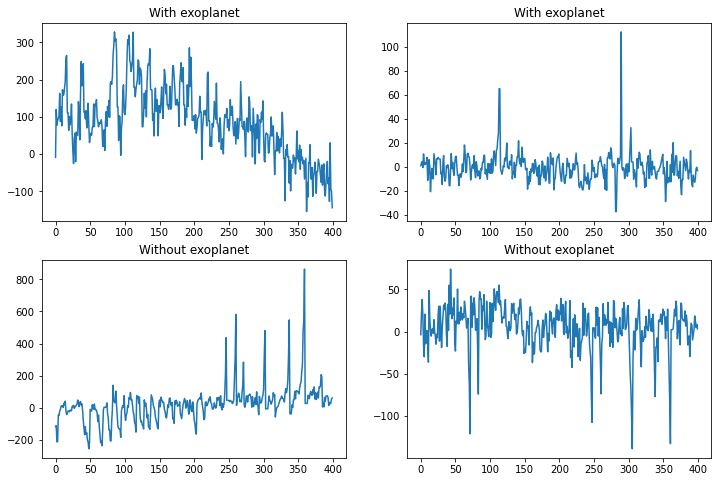

In [5]:
figure, axis = plt.subplots(2, 2)
figure.set_figheight(8)
figure.set_figwidth(12)

axis[0, 0].plot(np.array(train_data.iloc[0,1000:1400]))
axis[0, 0].set_title("With exoplanet")
axis[0, 1].plot(np.array(train_data.iloc[12,1000:1400]))
axis[0, 1].set_title("With exoplanet")
axis[1, 0].plot(np.array(train_data.iloc[82,1000:1400]))
axis[1, 0].set_title("Without exoplanet")
axis[1, 1].plot(np.array(train_data.iloc[1002,1000:1400]))
axis[1, 1].set_title("Without exoplanet")

plt.show()

Here is the explanation given on Kaggle : "As you can imagine, planets themselves do not emit light, but the stars that they orbit do. If said star is watched over several months or years, there may be a regular 'dimming' of the flux (the light intensity). This is evidence that there may be an orbiting body around the star; such a star could be considered to be a 'candidate' system. Further study of our candidate system, for example by a satellite that captures light at a different wavelength, could solidify the belief that the candidate can in fact be 'confirmed'."

On the 4 examples plotted above, it seems hard to notice a periodic dimming with our eyes. A convolutional neural network can help with that task.

Since the training data set contains 5087 stars where only 36 has at least one confirmed exoplanet, we sample several sequence of length 200 out of these stars with exoplanets to make the generalization task easier. We also use a randomOverSampler method to have 1/2 of star with exoplanet and 1/2 without exoplanets.  

In [6]:
start_sequence = 1000
sequence_length = 200
star_with_exo = 36

#Take multiple sequence with exoplanet from the train data
data_with_exoplanet = np.array(train_data.iloc[:star_with_exo+1,1:])
slice_nb = int(data_with_exoplanet.shape[1]/sequence_length)
X_train = np.zeros((train_data.shape[0]-star_with_exo+star_with_exo*slice_nb-1,sequence_length))
y_train = np.zeros((train_data.shape[0]-star_with_exo+star_with_exo*slice_nb-1,))
for i in range(star_with_exo):
    for j in range(slice_nb):
        X_train[slice_nb*i+j] = data_with_exoplanet[i,j*sequence_length:(j+1)*sequence_length]
        y_train[slice_nb*i+j] = 2
X_train[slice_nb*star_with_exo:] = np.array(train_data.iloc[star_with_exo+1:,start_sequence:start_sequence+sequence_length])
y_train[slice_nb*star_with_exo:] = np.array(train_data.iloc[star_with_exo+1:,0])

#Oversampling of the minority class
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train,y_train)
y_train = y_train.reshape(-1,1)

# Test data
X_test = np.array(test_data.iloc[:,start_sequence:start_sequence+sequence_length])
y_test = np.array(test_data[['LABEL']]).reshape(-1,1)



# Training

In [8]:
kernel_number = 10
kernel_size = 3
average_size = 3
frequency_threshold = 500
outlier_threshold = 3
model = CNN_nn(input_size=1, kernel_number = kernel_number, sequence_length=sequence_length, kernel_size=kernel_size, average_size=average_size, frequency_threshold = frequency_threshold, outlier_threshold=outlier_threshold)

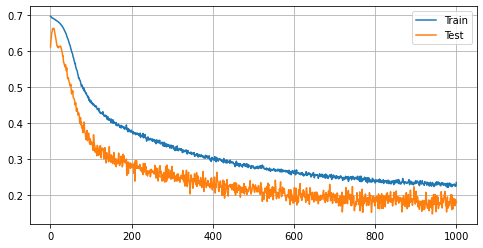

In [35]:
num_epochs = 1000
train_hist, test_hist = model.train(num_epochs, X_train, y_train, X_test, y_test)
fig = plt.figure(figsize = (8,4))
plt.plot(train_hist, label = 'Train')
plt.plot(test_hist, label = 'Test')
plt.legend()
plt.grid()
plt.show()

The next line saves the models parameters for future use

In [367]:
filepath = 'save/model1'
torch.save(model.state_dict(), filepath)

The next line loads the saved parameters

In [9]:
filepath = 'save/model1'
model.load_state_dict(torch.load(filepath))

<All keys matched successfully>

In [11]:
print('Train set')
model.print_confusion_matrix(X_train,y_train)
print('\n')
print('Test set')
model.print_confusion_matrix(X_test,y_test)

Train set
Confusion matrix: 
        0       1
0  4891.0   156.0
1   159.0  4894.0


Test set
Confusion matrix: 
     0      1
0  5.0   19.0
1  0.0  546.0


We have correctly detected all the exoplanet and misdetected 19 exoplanet on the test set. It is not bad !

# Feature embedding

We plot the last fully connected layer with a T-SNE to visualize how our model is classifying the two classes

/Users/thibaultalexandre/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/thibaultalexandre/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


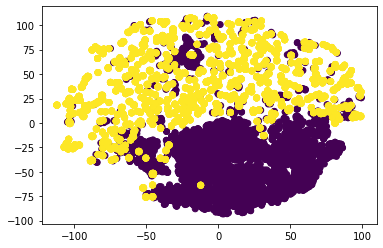

In [11]:
X_embedded = model.embed_features(X_train, y_train)

/Users/thibaultalexandre/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/thibaultalexandre/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


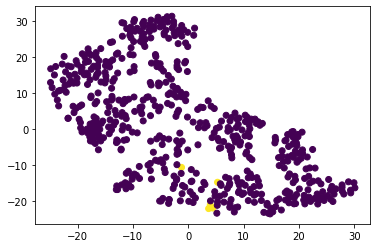

In [12]:
X_embedded = model.embed_features(X_test, y_test)

# Visualization of data

We plot some data

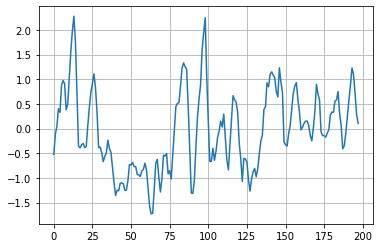

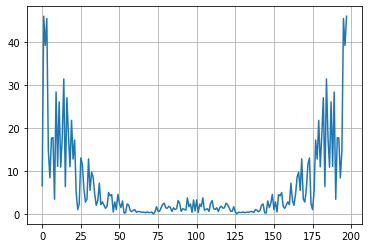

In [13]:
model.plot_features(X_test[2],500,3)

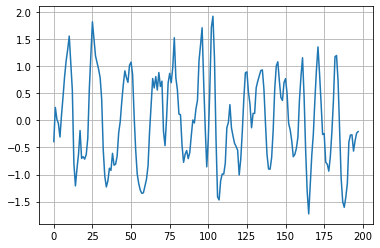

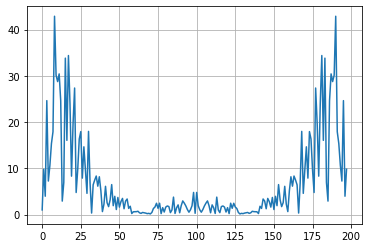

In [14]:
model.plot_features(X_test[10],500,3)